In this notebook we'll split the Biogen solubility dataset into training and test sets.  We'll then use the training and test sets to build machine learning models. 

In [1]:
import pandas as pd
import datamol as dm
from molfeat.trans import MoleculeTransformer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, LGBMClassifier
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
import datamol as dm
from helper import scaffold_split
from tqdm.auto import tqdm
import seaborn as sns
import json
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Read the data

In [2]:
df = pd.read_csv("biogen_solubility.csv")
len(df)

2173

Look at the univariate statistics for LogS 

In [3]:
df.logS.describe()

count    2173.000000
mean       -4.236993
std         0.709761
min        -6.669644
25%        -4.346474
50%        -3.920755
75%        -3.798661
max        -3.188304
Name: logS, dtype: float64

Instantiate a transformer object to generate RDKit 2D descriptors

In [4]:
transformer = MoleculeTransformer(featurizer='desc2D',dype=float)

Generate the descriptors

In [5]:
with dm.without_rdkit_log():
    desc2D = transformer(df.SMILES.values)

Add the descriptors to the dataframe

In [6]:
df['desc2D'] = list(desc2D)

Define a routine to perform adversarial validation. As we perform each regresssion fold, we'll also record the AUROC from the adversarial validation.  After that, we'll if we have a relationship between the adversarial AUCROC and Pearson's r or MAE.

In [7]:
def adversarial_validation(train_in, test_in):
    train_in = train_in.copy()
    test_in = test_in.copy()
    train_in['label'] = 0
    test_in['label'] = 1
    tmp_df = pd.concat([train_in,test_in])
    train, test = train_test_split(tmp_df)
    lgbc = LGBMClassifier()
    lgbc.fit(np.stack(train.desc2D),train.label)
    pred = lgbc.predict(np.stack(test.desc2D))
    auc = roc_auc_score(test.label,pred)
    return auc    

Perform 10 folds of cross validation with random splits

In [8]:
random_split_res_list = []
for i in tqdm(range(0,10)):
    lgbm = LGBMRegressor()
    train, test = train_test_split(df,random_state=i, test_size=0.2)
    auc = adversarial_validation(train, test)
    lgbm.fit(np.stack(train.desc2D),train.logS)
    pred = lgbm.predict(np.stack(test.desc2D))    
    r = pearsonr(test.logS, pred).statistic
    mae = mean_absolute_error(test.logS, pred)
    random_split_res_list.append([r, mae, auc])
random_split_df = pd.DataFrame(random_split_res_list,columns=["r","mae","auc"])
random_split_df['method'] = 'random'

  0%|          | 0/10 [00:00<?, ?it/s]

Perform 10 folds of cross validation with scaffold splits

In [9]:
scaffold_split_res_list = []
for i in tqdm(range(0,10)):
    lgbm = LGBMRegressor()
    train_idx, test_idx = scaffold_split(df.SMILES,seed=i)
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    auc = adversarial_validation(train, test)
    lgbm.fit(np.stack(train.desc2D),train.logS)
    pred = lgbm.predict(np.stack(test.desc2D))    
    r = pearsonr(test.logS, pred).statistic
    mae = mean_absolute_error(test.logS, pred)
    scaffold_split_res_list.append([r, mae, auc])
scaffold_split_df = pd.DataFrame(scaffold_split_res_list, columns=["r","mae","auc"])
scaffold_split_df['method'] = 'scaffold'

  0%|          | 0/10 [00:00<?, ?it/s]

Read the SIMPD splits from disk

In [10]:
simpd_fs = open("SIMPD_splits.json")
simpd_splits = json.load(simpd_fs)
simpd_train = simpd_splits['train']
simpd_test = simpd_splits['test']

Perform 10 folds of cross validation with SIMPD splits

In [11]:
simpd_split_res_list = []
for i in tqdm(range(0,10)):
    lgbm = LGBMRegressor()
    train_idx = simpd_train[i]
    test_idx = simpd_test[i]
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    auc = adversarial_validation(train, test)
    lgbm.fit(np.stack(train.desc2D),train.logS)
    pred = lgbm.predict(np.stack(test.desc2D))    
    r = pearsonr(test.logS, pred).statistic
    mae = mean_absolute_error(test.logS, pred)
    simpd_split_res_list.append([r, mae, auc])
simpd_split_df = pd.DataFrame(simpd_split_res_list, columns=["r","mae","auc"])
simpd_split_df['method'] = 'simpd'

  0%|          | 0/10 [00:00<?, ?it/s]

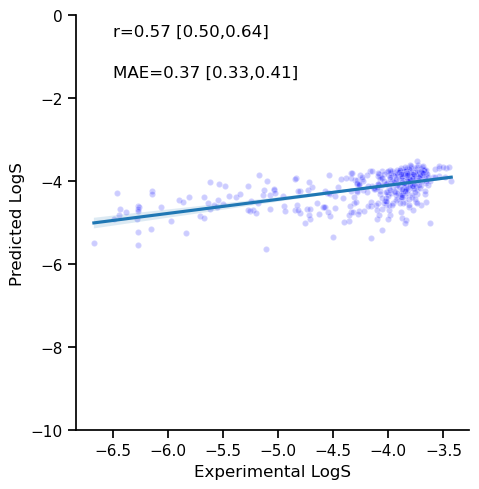

In [12]:
from plot_regression import plot_regression

plot_regression(test.logS, pred)

Combine the results from the ML models into one dataframe

In [ ]:
combo_df = pd.concat([random_split_df, scaffold_split_df, simpd_split_df])

Plot the comparison

Plot distributions for Pearson's r for the 3 different split methods. 

In [ ]:
sns.set_context('notebook')
ax = sns.boxplot(x="method",y="r",data=combo_df)
#ax = sns.kdeplot(x="r",hue='method',data=combo_df)
ax.set_title("Comparing Pearson's r")
ax.set_xlabel("Split Method")

Plot distributions for MAE r for the 3 different split methods. 

In [ ]:
sns.set_context('notebook')
ax = sns.boxplot(x="method",y="mae",data=combo_df)
#ax = sns.kdeplot(x="mae",hue='method',data=combo_df)
ax.set_title("Comparing MAE");
ax.set_xlabel("Split Method")
ax.set_ylabel("MAE")

Plot the relationship between AUC from adversarial validation and Pearson's r.  There seems to be a rough relationship for the random and SIMPD splits.  I don't see a relationship for the scaffold splits.   This is tough to call give the narrow range for AUROC and r. 

In [ ]:
sns.scatterplot(x="auc", y="r", hue="method", data=combo_df);

Plot the relationship between AUC from adversarial validation and MAE. I don't see a relationship here. 

In [ ]:
sns.scatterplot(x="auc", y="mae", hue="method", data=combo_df);

Make boxplots of the AUROC for adversarial validation for the three splitting methods. 

In [ ]:
ax = sns.boxplot(x="method",y="auc",data=combo_df)
ax.set_xlabel("Split Method")
ax.set_ylabel("AUC")

Examine the range of MAE for the SIMPD splits. 

In [ ]:
combo_df.query("method == 'simpd'").mae.describe()

Examine the range of Pearson's r for the SIMPD splits. 

In [ ]:
combo_df.query("method == 'simpd'").r.describe()

Examine the magnitude of the MAE if we simply pick a random value between -7 and -3. 

In [ ]:
guess_list = []
for i in range(0,1000):
    df['guess'] = np.random.uniform(-7,-3)
    guess_list.append(mean_absolute_error(df.logS,df.guess))
pd.Series(guess_list).describe()